# ECE 271A - Homework 1: Cheetah Image Segmentation

This notebook implements a Bayesian classifier to segment the `cheetah.bmp` image into foreground (cheetah) and background (grass) components.

## 1. Setup and Data Loading

In [7]:
import numpy as np
from scipy.io import loadmat
from scipy.fft import dctn
import imageio.v2 as imageio
import matplotlib.pyplot as plt

try:
    training_data = loadmat('TrainingSamplesDCT_8.mat')
    TrainsampleDCT_FG = training_data['TrainsampleDCT_FG']
    TrainsampleDCT_BG = training_data['TrainsampleDCT_BG']
except FileNotFoundError:
    print("Training data file not found. 'TrainingSamplesDCT_8.mat' should be in the same directory.")

try:
    zigzag_pattern = np.loadtxt('Zig-Zag Pattern.txt', dtype=int)
except FileNotFoundError:
    print("Zig-Zag pattern file not found. Make sure 'Zig-Zag Pattern.txt' should be in the same directory.")

print(f"Loaded {TrainsampleDCT_FG.shape[0]} foreground (cheetah) training samples.")
print(f"Loaded {TrainsampleDCT_BG.shape[0]} background (grass) training samples.")

Loaded 250 foreground (cheetah) training samples.
Loaded 1053 background (grass) training samples.


## Part (a): Estimate Prior Probabilities

A reasonable estimate for the prior probabilities, $P(Y=\text{cheetah})$ and $P(Y=\text{grass})$, is the proportion of training samples belonging to each class.

In [8]:
n_fg = TrainsampleDCT_FG.shape[0]
n_bg = TrainsampleDCT_BG.shape[0]
n_total = n_fg + n_bg

prior_cheetah = n_fg / n_total
prior_grass = n_bg / n_total

print(f"Prior P(Y=cheetah): {prior_cheetah:.4f}")
print(f"Prior P(Y=grass):   {prior_grass:.4f}")

Prior P(Y=cheetah): 0.1919
Prior P(Y=grass):   0.8081


## Part (b): Estimate Class-Conditional Probabilities

The feature, $X$, is the index (from 1 to 64) of the DCT coefficient with the second-largest energy. We estimate the class-conditional probabilities, $P(X|Y=\text{cheetah})$ and $P(X|Y=\text{grass})$, by creating a histogram of these feature values for each class from the training data.

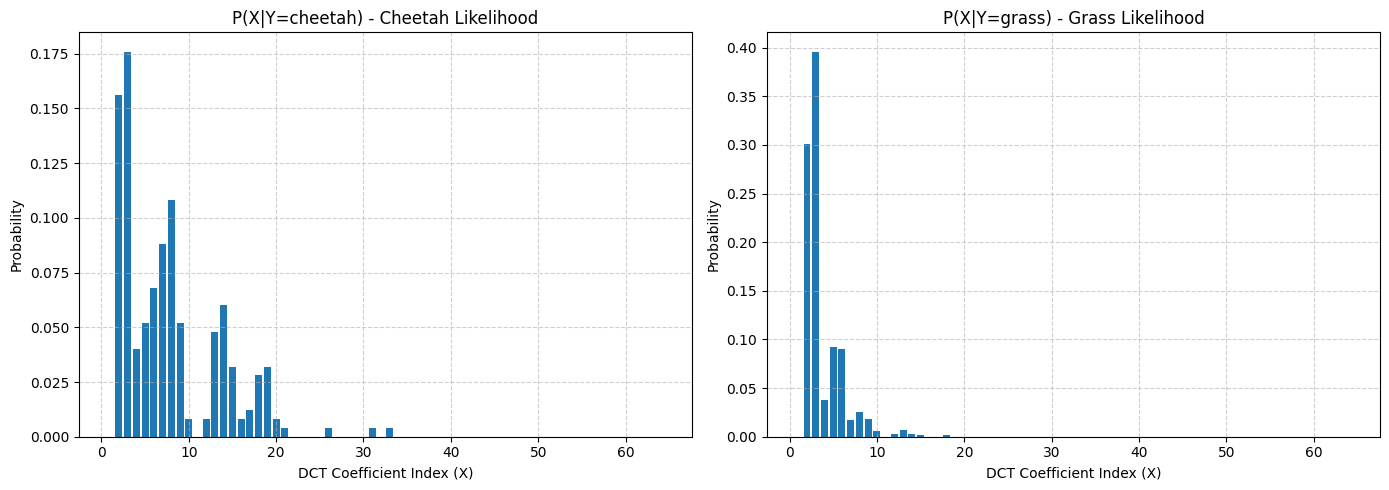

In [9]:
def extract_features(data):
    """Extracts the index of the 2nd largest absolute value for each sample."""
    abs_data = np.abs(data)
    sorted_indices = np.argsort(abs_data, axis=1)[:, ::-1]
    return sorted_indices[:, 1] + 1

features_fg = extract_features(TrainsampleDCT_FG)
features_bg = extract_features(TrainsampleDCT_BG)

# Create histograms for the likelihoods
# Bins are from 1 to 65 to cover indices 1-64
bins = np.arange(1, 66)

hist_fg, _ = np.histogram(features_fg, bins=bins)
hist_bg, _ = np.histogram(features_bg, bins=bins)

# Normalize histograms to get probabilities (likelihoods)
likelihood_cheetah = hist_fg / n_fg
likelihood_grass = hist_bg / n_bg

# Plotting the likelihoods
plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
plt.bar(np.arange(1, 65), likelihood_cheetah)
plt.title('P(X|Y=cheetah) - Cheetah Likelihood')
plt.xlabel('DCT Coefficient Index (X)')
plt.ylabel('Probability')
plt.grid(True, linestyle='--', alpha=0.6)

plt.subplot(1, 2, 2)
plt.bar(np.arange(1, 65), likelihood_grass)
plt.title('P(X|Y=grass) - Grass Likelihood')
plt.xlabel('DCT Coefficient Index (X)')
plt.ylabel('Probability')
plt.grid(True, linestyle='--', alpha=0.6)

plt.tight_layout()
plt.show()

## Part (c): Classify the Image using Bayesian Decision Rule

Now apply our trained classifier to the `cheetah.bmp` image. For each 8x8 block in the image :
1.  Compute the 2D DCT.
2.  Flatten the DCT coefficients into a 1D vector using the zig-zag pattern.
3.  Find the index of the 2nd largest absolute coefficient.
4.  Apply the Minimum Probability of Error rule: 
    $\hat{Y} = \arg\max_{Y} P(X|Y)P(Y)$
5.  Assign the resulting class to generate a segmentation mask.

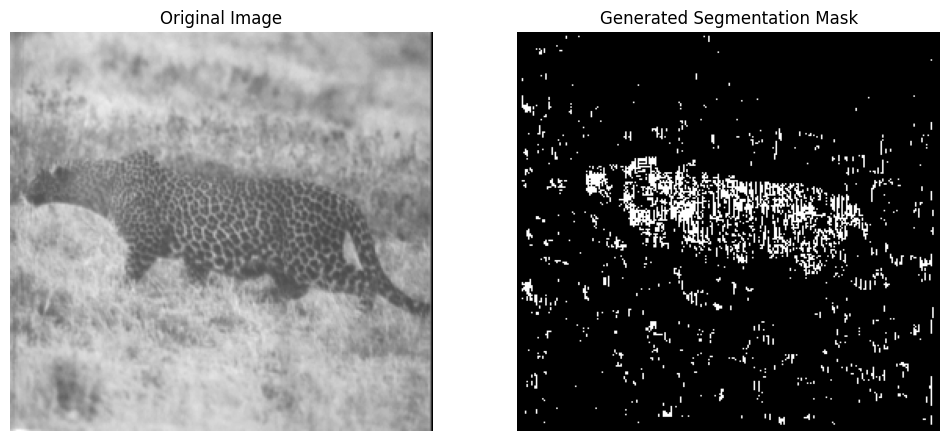

In [10]:
try:
    image = imageio.imread('cheetah.bmp', pilmode='L')
    mask_true = imageio.imread('cheetah_mask.bmp')
except FileNotFoundError:
    print("Image files not found. Make sure 'cheetah.bmp' and 'cheetah_mask.bmp' are present.")

# Convert image to double precision in [0, 1] range
image = image.astype(np.float64) / 255.0

height, width = image.shape
block_size = 8

mask_height = height - block_size + 1
mask_width = width - block_size + 1
segmentation_mask = np.zeros((mask_height, mask_width))

# Create a mapping from zig-zag order to 2D DCT coordinates to flatten the array
zigzag_flat = zigzag_pattern.flatten()
inverse_zigzag = np.empty_like(zigzag_flat)
inverse_zigzag[zigzag_flat] = np.arange(len(zigzag_flat))

for i in range(mask_height):
    for j in range(mask_width):
        # Extract 8x8 block
        block = image[i : i + block_size, j : j + block_size]
        
        # Apply 2D DCT
        dct_block = dctn(block, type=2, norm='ortho')
        
        # Flatten using zig-zag scan
        dct_vector = dct_block.flatten()[inverse_zigzag]
        
        # Extract the feature
        feature_index_0based = np.argsort(np.abs(dct_vector))[::-1][1]
        feature = feature_index_0based + 1
        
        # Apply Bayes Decision Rule
        epsilon = 1e-10
        posterior_cheetah = np.log(prior_cheetah) + np.log(likelihood_cheetah[feature - 1] + epsilon)
        posterior_grass = np.log(prior_grass) + np.log(likelihood_grass[feature - 1] + epsilon)
        
        if posterior_cheetah > posterior_grass:
            segmentation_mask[i, j] = 1 # 1 = cheetah (foreground)
        else:
            segmentation_mask[i, j] = 0 # 0 = grass (background)

# Pad the mask to match original image dimensions for visualization and error calculation
# The padding amount is (block_size - 1) / 2 on each side, rounded.
pad_amount = block_size // 2 - 1
padded_mask = np.pad(segmentation_mask, pad_width=((pad_amount, pad_amount+1), (pad_amount, pad_amount+1)), mode='constant', constant_values=0)

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.imshow(image, cmap='gray')
plt.title('Original Image')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(padded_mask, cmap='gray')
plt.title('Generated Segmentation Mask')
plt.axis('off')

plt.show()

## Part (d): Compute the Probability of Error

Finally, compare generated segmentation mask with the provided ground truth mask (`cheetah_mask.bmp`) to calculate the probability of error, which is the fraction of misclassified pixels.

Total pixels: 68850
Mismatched pixels: 11566
Probability of Error: 0.1680 or 16.80%


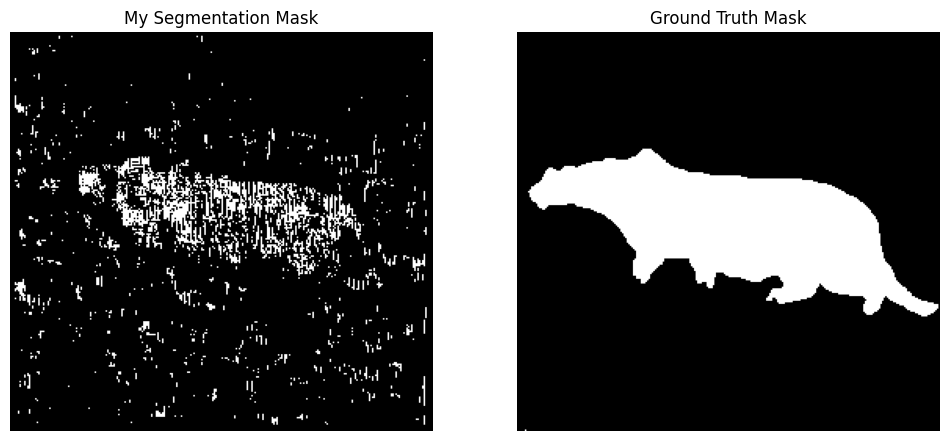

In [11]:
# Ensure the ground truth mask is binary (0 or 1)
mask_true_binary = (mask_true / 255).astype(int)

# Ensure mask is the same size and type
padded_mask_binary = padded_mask.astype(int)
if padded_mask_binary.shape != mask_true_binary.shape:
    print("Warning: Padded mask and true mask dimensions do not match!")
    padded_mask_binary = np.resize(padded_mask_binary, mask_true_binary.shape)

mismatched_pixels = np.sum(padded_mask_binary != mask_true_binary)
total_pixels = mask_true_binary.size

error_rate = mismatched_pixels / total_pixels

print(f"Total pixels: {total_pixels}")
print(f"Mismatched pixels: {mismatched_pixels}")
print(f"Probability of Error: {error_rate:.4f} or {error_rate * 100:.2f}%")

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.imshow(padded_mask_binary, cmap='gray')
plt.title('My Segmentation Mask')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(mask_true_binary, cmap='gray')
plt.title('Ground Truth Mask')
plt.axis('off')

plt.show()